In [1]:
!pip install meteostat

from meteostat import Point, Daily, Stations
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime as dt
import seaborn
import calendar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_train_partial = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test_partial = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

**Get Weather Data**
* First we get the ISO code for Ecuador (EC)
* We get a list of weather stations in EC and choose one
* We load min/max/avg temperature and precipitation from weather station
* We clean the data, forward fill, check if there are any gaps
* Smoothing data

Improvement: specify region ISO code as well instead of one station

In [3]:
stations = Stations()
stations = stations.region('EC')
stations.fetch(10)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
84001,Seymour Galapagos,EC,W,84001,SEGS,-0.4500,-90.2667,16.0,Pacific/Galapagos,1942-08-01,2023-07-02,1942-09-15,1945-09-30,1942-01-01,1945-01-01
84008,San Cristobal Galapagos,EC,W,84008,SEST,-0.9000,-89.6000,6.0,Pacific/Galapagos,1973-06-16,2023-07-02,1985-04-18,2023-07-04,1975-01-01,2021-01-01
84010,San Cristobal Aeropuerto (galapagos) / San Cri...,EC,W,84010,<NA>,-0.9103,-89.6175,18.0,Pacific/Galapagos,2010-09-01,2023-05-13,NaT,NaT,NaT,NaT
84015,Chone / San Pablo / Peludo,EC,M,84015,SECH,-0.7000,-80.1167,69.0,Pacific/Galapagos,2006-03-06,2018-02-28,NaT,NaT,NaT,NaT
84018,Esmeraldas-Tachina,EC,E,84018,SEES,0.9667,-79.6333,7.0,Pacific/Galapagos,1973-01-01,2008-11-06,NaT,NaT,NaT,NaT
84027,Tulcan / El Rosal,EC,C,84027,SETU,0.8167,-77.7000,2950.0,Pacific/Galapagos,1938-09-02,2023-06-30,NaT,NaT,NaT,NaT
84036,San Gabriel,EC,C,84036,<NA>,0.6042,-77.8194,2860.0,America/Guayaquil,2003-04-04,2023-05-13,2011-07-16,2023-07-03,2009-01-01,2021-01-01
84043,Ibarra / Atahualpa,EC,I,84043,SEIB,0.3500,-78.1333,2228.0,Pacific/Galapagos,1980-04-01,2018-11-01,NaT,NaT,1975-01-01,1982-01-01
84050,La Concordia,EC,P,84050,<NA>,0.0267,-79.3714,360.0,America/Guayaquil,2003-04-04,2023-05-13,2005-09-20,2023-07-03,2009-01-01,2021-01-01


In [4]:
# Set time period
start = pd.Timestamp(df_train_partial.date.min())
end = pd.Timestamp(df_test_partial.date.max())

# Get daily data for 2018
df_weather = Daily('84036', start, end)
df_weather = df_weather.fetch()[['tavg', 'tmin', 'tmax', 'prcp']]
df_weather['tavg_ma7'] = df_weather.tavg.rolling(7).mean().bfill()
df_weather['prcp_ma7'] = df_weather.prcp.rolling(7).mean().bfill()


df_weather.prcp = df_weather.prcp.fillna(0)
df_weather = df_weather.resample('D').first().interpolate(method='linear').bfill() #  fill first value
df_weather = df_weather.ffill()
df_weather = df_weather.reset_index().rename({'time': 'date'}, axis=1)
df_weather.date = pd.to_datetime(df_weather.date)

<Axes: >

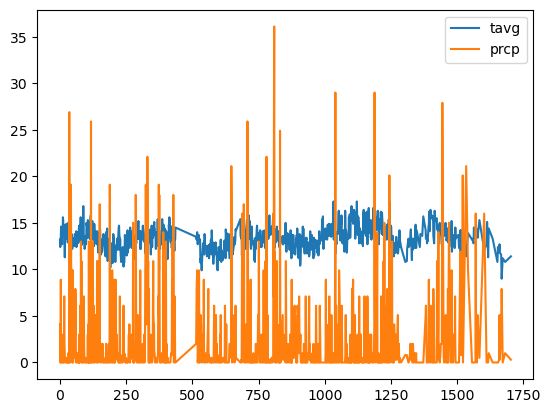

In [5]:
df_weather.plot(y=['tavg', 'prcp'])

In [6]:
# convert to timestamp and remove leading 0s
df_train_partial.date = pd.to_datetime(df_train_partial.date)
df_test_partial.date = pd.to_datetime(df_test_partial.date)
df_train_partial = df_train_partial.sort_values(['store_nbr', 'family', 'date']).groupby(['store_nbr', 'family']).apply(lambda x: x[x.sales.cumsum()>0]).reset_index(drop=True)

**Cleaning Oil Data**
* Linearly interpolate weekends
* Add 7-day and 30-day moving averages
* Add 7-day and 30-day rolling max

In [7]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_oil = df_oil.set_index('date')
df_oil.index = pd.to_datetime(df_oil.index)
df_oil = df_oil.resample('D').first().interpolate(method='linear').bfill() #  fill first value
df_oil = df_oil.rename({'dcoilwtico': 'price'}, axis=1)
df_oil['price_7d_ma'] = df_oil.price.rolling(7).mean().bfill()
df_oil['price_30d_ma'] = df_oil.price.rolling(30).mean().bfill()
df_oil['price_7d_max'] = df_oil.price.rolling(7).max().bfill()
df_oil['price_30d_max'] = df_oil.price.rolling(30).max().bfill()
df_oil['price_7d_min'] = df_oil.price.rolling(7).min().bfill()
df_oil['price_30d_min'] = df_oil.price.rolling(30).min().bfill()

**Cleaning Holiday Data**
* Holidays such as Navidad-1, -2, -3 etc are all cleaned to Navidad, as it might be an important feature
* Splitting holiday types into different dataframes (national, regional, local)

In [8]:
def clean_hol(x):
    if ':' in x:
        x = x.split(':')[0]
    if '-' in x:
        x = x.split('-')[0]
    if '+' in x:
        x = x.split('+')[0]
        
    if 'Cantonizacion' in x:
        x = 'Cantonizacion'
    if 'Provincializacion' in x:
        x = 'Provincializacion'
    if 'Navidad' in x:
        x = 'Navidad'
    if 'Fundacion' in x:
        x = 'Fundacion'
        
    return x.strip('Puente').lower()

df_hols = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_hols['holiday_description_clean'] = df_hols.description.apply(clean_hol)
df_hols = df_hols[~df_hols.transferred].drop(['transferred'], axis=1)
df_hols = df_hols.rename(
    {'type': 'holiday_type', 
     'description': 'holiday_description'
    }, axis=1)
df_hols.date = pd.to_datetime(df_hols.date)
    
holiday_loc = df_hols[df_hols.locale == 'Local']
holiday_reg = df_hols[df_hols.locale == 'Regional']
holiday_nat = df_hols[df_hols.locale == 'National']

holiday_loc = holiday_loc.rename(columns={'locale_name': 'city' })
holiday_reg = holiday_reg.rename(columns={'locale_name': 'state'})

In [9]:
df_stores = df_stores.rename({'type': 'store_type',}, axis=1)

**Calendar DataFrame**
* Describing features of each day such as:
    * does it fall on a weekend?
    * what day of week is it?
    * what month is it? etc

In [10]:
min_date = df_train_partial.date.min()
max_date = df_test_partial.date.max()
df_cal = pd.DataFrame(index=pd.date_range(min_date, max_date))
df_cal['day_of_week'] = df_cal.index.map(dt.isoweekday)
df_cal['is_weekend'] = df_cal.day_of_week >= 5
df_cal['month_of_year'] = df_cal.index.map(lambda x: x.month)
df_cal['day_of_year'] = df_cal.index.map(lambda x: x.timetuple().tm_yday)
df_cal['week_of_year'] = df_cal.day_of_year//7+1
df_cal['day_of_month'] = df_cal.index.map(lambda x: x.day)
df_cal['is_wage_day'] = df_cal.index.map(lambda x: x.day in [15, calendar.monthrange(x.year, x.month)[1]])
df_cal['is_wage_day_after'] = df_cal.is_wage_day.shift().fillna(False)

In [11]:
n = 3
print('-'*10, 'Oil Prices', '-'*10)
print(df_oil.head(n))
print('-'*10, 'Calendar', '-'*10)
print(df_cal.head(n))
print('-'*10, 'Holidays', '-'*10)
print(df_hols.head(n))
print('-'*10, 'Stores', '-'*10)
print(df_stores.head(n))
print('-'*10, 'Training data', '-'*10)
print(df_train_partial.head(n))
print('-'*10, 'Test data', '-'*10)
print(df_test_partial.head(n))
print('-'*10, 'Transactions', '-'*10)
print(df_transactions.head(n))
print('-'*10, 'Weather', '-'*10)
print(df_weather.head(n))

---------- Oil Prices ----------
            price  price_7d_ma  price_30d_ma  price_7d_max  price_30d_max  \
date                                                                        
2013-01-01  93.14    93.127143     94.607333          93.2          97.98   
2013-01-02  93.14    93.127143     94.607333          93.2          97.98   
2013-01-03  92.97    93.127143     94.607333          93.2          97.98   

            price_7d_min  price_30d_min  
date                                     
2013-01-01         92.97          92.97  
2013-01-02         92.97          92.97  
2013-01-03         92.97          92.97  
---------- Calendar ----------
            day_of_week  is_weekend  month_of_year  day_of_year  week_of_year  \
2013-01-01            2       False              1            1             1   
2013-01-02            3       False              1            2             1   
2013-01-03            4       False              1            3             1   

            day

<Axes: xlabel='date'>

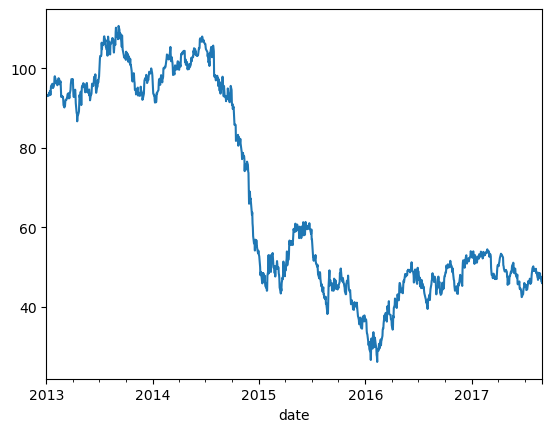

In [12]:
df_oil['price'].plot()

In [13]:
def preprocess(df_in, label_encoder_map=None):
    print('merging...')
    df_out = df_in\
        .merge(df_stores, how='inner', on='store_nbr')\
        .merge(df_oil, how='inner', on='date')\
        .merge(df_weather, how='inner', on='date')\
        .merge(df_cal, how='inner', left_on='date', right_index=True).copy()


    df_out_loc = pd.merge(df_out, holiday_loc, on=['date', 'city'], how='left')
    df_out_loc = df_out_loc[~(df_out_loc.holiday_type == 'Holiday')]
    
    df_out_reg = pd.merge(df_out, holiday_reg, on=['date', 'state'], how='left')
    df_out_reg = df_out_reg[~(df_out_reg.holiday_type == 'Holiday')]
    
    df_out_nat = pd.merge(df_out, holiday_nat, on=['date'], how='left') 
    df_out_nat = df_out_nat[~(df_out_nat.holiday_type == 'Holiday')]
    
    df_out = pd.concat([df_out_loc, df_out_reg, df_out_nat])
    

    df_out = df_out[~df_out.id.duplicated(keep='first')]
    df_out = df_out.drop(['locale', 'locale_name'], axis=1, errors='ignore')
    
    print(df_out.head(50))
    
    col_encode = [
        'family',
        'holiday_type',
        'holiday_description',
        'holiday_description_clean',
        'city',
        'state',
        'store_type',
    ]
    
    scaler = None
    if 'sales' in df_out:
        print('Scaling...')
        scaler = MinMaxScaler()
#         scaler = PowerTransformer(method='box-cox', standardize=False)
#         scaler = PowerTransformer(method='yeo-johnson', standardize=False)
#         scaler = QuantileTransformer(output_distribution='normal', random_state=0)
#         scaler = StandardScaler()
        df_out['sales_transformed'] = scaler.fit_transform(np.array(df_out.sales).reshape(-1, 1))
    
    print('computing label encoding...')
    if label_encoder_map is None:
        label_encoder_map = {}
        for col in col_encode:
            if col not in df_out: continue
            le = preprocessing.LabelEncoder()
            df_out[col] = le.fit_transform(df_out[col])
            label_encoder_map[col] = le
    else:
        for col in col_encode:
            if col not in df_out: continue
            le = label_encoder_map[col]
            df_out[col] = le.transform(df_out[col])
            
    assert df_in.shape[0] == df_out.shape[0]
    return df_out, label_encoder_map, scaler  # should fillna only to specific columns!

df_train, label_encoder_map, scaler = preprocess(df_train_partial)
print(df_train.columns)

merging...
      id       date  store_nbr            family        sales  onpromotion  \
0   1782 2013-01-02          1        AUTOMOTIVE     2.000000            0   
1   1784 2013-01-02          1            BEAUTY     2.000000            0   
2   1785 2013-01-02          1         BEVERAGES  1091.000000            0   
3   1787 2013-01-02          1      BREAD/BAKERY   470.652000            0   
4   1789 2013-01-02          1          CLEANING  1060.000000            0   
5   1790 2013-01-02          1             DAIRY   579.000000            0   
6   1791 2013-01-02          1              DELI   164.069000            0   
7   1792 2013-01-02          1              EGGS   246.000000            0   
8   1793 2013-01-02          1      FROZEN FOODS   131.000000            0   
9   1794 2013-01-02          1         GROCERY I  2652.000000            0   
10  1795 2013-01-02          1        GROCERY II    31.000000            0   
11  1796 2013-01-02          1          HARDWARE     

<Axes: title={'center': 'sales'}, xlabel='holiday_description_clean'>

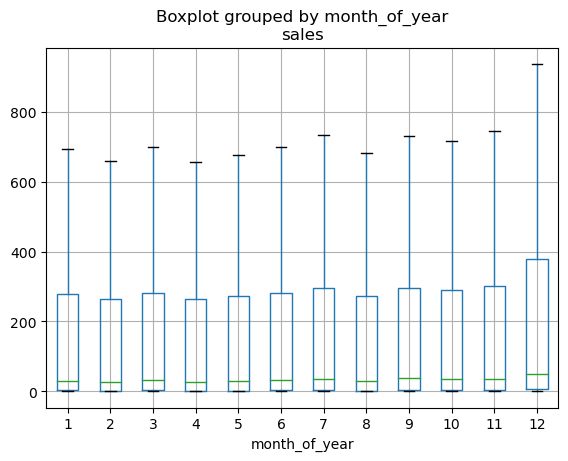

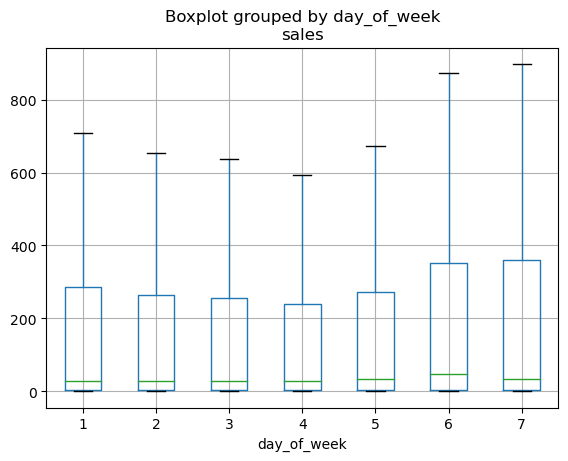

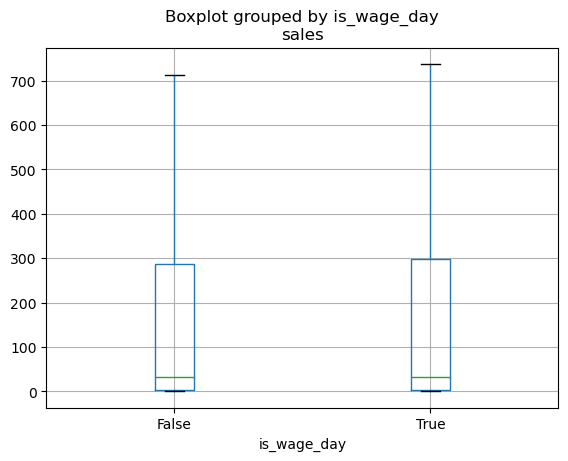

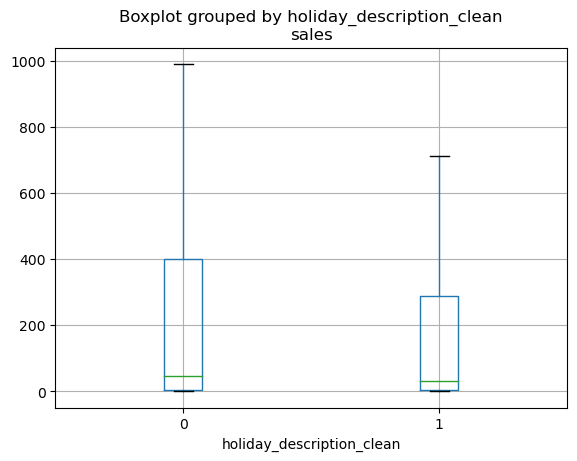

In [14]:
df_train.boxplot(column='sales', by='month_of_year', showfliers=False)
df_train.boxplot(column='sales', by='day_of_week', showfliers=False)
df_train.boxplot(column='sales', by='is_wage_day', showfliers=False)
df_train.boxplot(column='sales', by='holiday_description_clean', showfliers=False)

<Axes: xlabel='prcp', ylabel='sales'>

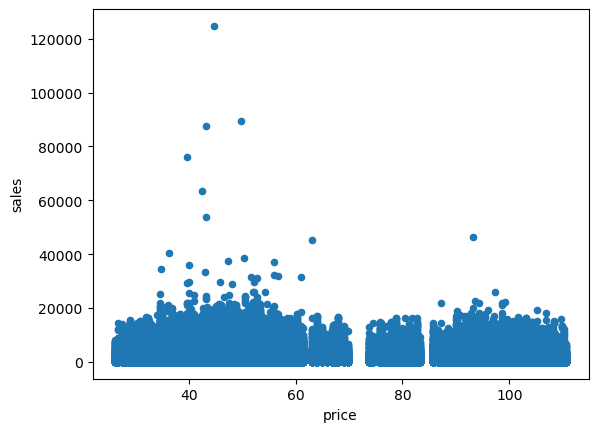

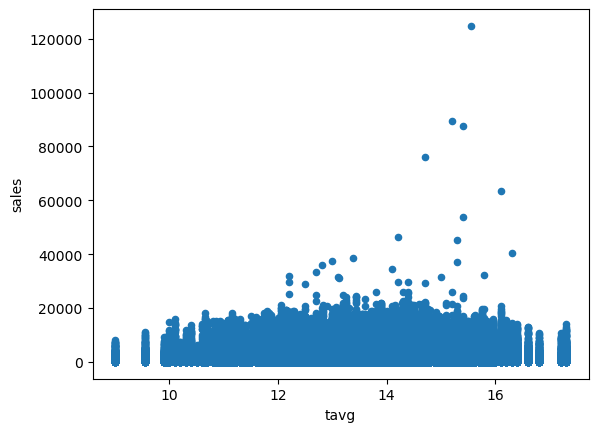

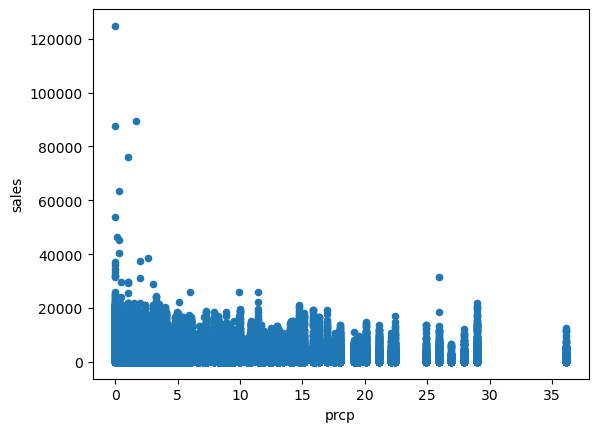

In [15]:
df_train[['price', 'sales']].plot.scatter(x='price', y='sales')
df_train[['tavg', 'sales']].plot.scatter(x='tavg', y='sales')
df_train[['prcp', 'sales']].plot.scatter(x='prcp', y='sales')

In [16]:
df_train = df_train.sort_values(['store_nbr', 'family', 'date'])

<Axes: >

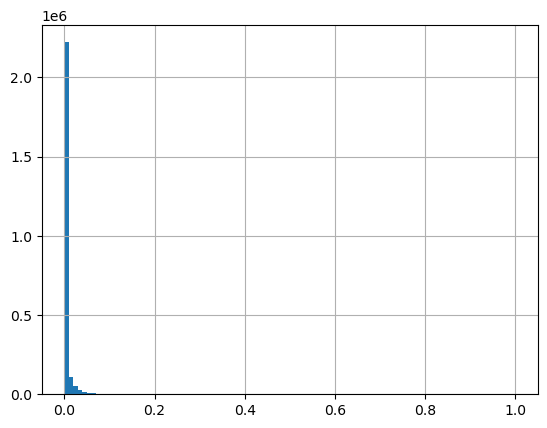

In [17]:
df_train.sales_transformed.hist(bins=100)

In [18]:
corr_matrix = df_train.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,price,price_7d_ma,price_30d_ma,price_7d_max,price_30d_max,price_7d_min,price_30d_min,tavg,tmin,tmax,prcp,tavg_ma7,prcp_ma7,day_of_week,is_weekend,month_of_year,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed
id,1.000000,0.012992,0.030270,0.036253,0.198075,0.006041,-0.003664,0.015515,-0.014736,-0.817397,-0.818783,-0.824594,-0.823294,-0.835867,-0.814266,-0.811657,0.054927,0.057089,0.079360,0.057217,0.189517,0.131664,-0.002669,-0.002025,0.051948,0.053217,0.053257,0.002745,0.003487,-0.000723,-0.008749,-0.014925,-0.009399,0.036253
store_nbr,0.012992,1.000000,0.002174,0.060037,0.017163,-0.320501,-0.203929,-0.412796,-0.074281,-0.009935,-0.009886,-0.009738,-0.009897,-0.009751,-0.009869,-0.009711,-0.001463,0.000092,-0.001271,0.000329,0.000105,-0.001315,0.000012,0.000024,0.002453,0.002445,0.002445,0.000061,0.000046,-0.000027,0.003776,-0.002484,0.003296,0.060037
family,0.030270,0.002174,1.000000,-0.141874,-0.059490,0.003795,0.006691,-0.003727,0.008884,-0.031051,-0.030880,-0.030258,-0.030715,-0.029767,-0.030976,-0.030605,0.004003,0.002673,-0.000939,-0.002563,0.004962,-0.004180,-0.000022,-0.000006,0.001110,0.001151,0.001151,0.000099,-0.000047,0.000030,-0.000024,0.000127,-0.000014,-0.141874
sales,0.036253,0.060037,-0.141874,1.000000,0.419392,0.058494,0.077423,-0.112970,0.036900,-0.031459,-0.031225,-0.030609,-0.031182,-0.030944,-0.031356,-0.030386,0.008631,0.006027,0.010736,0.003034,0.016902,0.007813,0.041207,0.043418,0.020578,0.019380,0.019185,-0.013828,0.001119,0.007129,-0.003919,-0.001392,-0.003869,1.000000
onpromotion,0.198075,0.017163,-0.059490,0.419392,1.000000,0.007209,0.014569,-0.012235,0.002559,-0.142015,-0.142547,-0.144866,-0.143992,-0.147876,-0.141406,-0.142011,0.016379,0.009481,0.030694,0.018575,0.048118,0.038210,-0.003091,-0.000392,0.027823,0.028272,0.028172,0.002138,0.002828,-0.001185,-0.002854,-0.002938,-0.002932,0.419392
city,0.006041,-0.320501,0.003795,0.058494,0.007209,1.000000,0.483648,-0.083821,0.092464,-0.005939,-0.005936,-0.005954,-0.005972,-0.006029,-0.005908,-0.005876,0.000609,0.000684,0.000879,0.000387,0.002020,0.000421,-0.000019,-0.000020,0.000180,0.000182,0.000183,-0.000066,0.000038,0.000032,-0.010289,0.003878,-0.009346,0.058494
state,-0.003664,-0.203929,0.006691,0.077423,0.014569,0.483648,1.000000,-0.233032,0.163249,0.003102,0.003132,0.003224,0.003128,0.003247,0.003126,0.003185,-0.001107,-0.000038,-0.000765,0.000226,-0.001233,-0.000627,0.000001,-0.000002,-0.000977,-0.000997,-0.000997,-0.000101,0.000019,0.000029,-0.008107,0.006184,-0.006853,0.077423
store_type,0.015515,-0.412796,-0.003727,-0.112970,-0.012235,-0.083821,-0.233032,1.000000,-0.278951,-0.015220,-0.015234,-0.015294,-0.015232,-0.015345,-0.015218,-0.015245,0.001787,0.001451,0.001048,0.000348,0.003445,0.002115,-0.000068,-0.000059,0.004735,0.004776,0.004776,0.000210,0.000019,0.000089,0.005480,0.000317,0.005263,-0.112970
cluster,-0.014736,-0.074281,0.008884,0.036900,0.002559,0.092464,0.163249,-0.278951,1.000000,0.012680,0.012817,0.013312,0.012955,0.013721,0.012693,0.012865,-0.005024,-0.001269,-0.005684,-0.000789,-0.008134,-0.004607,0.000037,0.000027,-0.000066,-0.000125,-0.000126,-0.000086,-0.000023,0.000011,-0.008274,-0.000111,-0.007570,0.036900
price,-0.817397,-0.009935,-0.031051,-0.031459,-0.142015,-0.005939,0.003102,-0.015220,0.012680,1.000000,0.998626,0.992139,0.998266,0.989082,0.998411,0.992942,-0.210361,-0.108715,-0.165945,-0.017775,-0.384528,-0.062786,0.002433,0.002321,0.005475,0.003470,0.003445,-0.001022,-0.001599,0.000248,0.003796,0.004228,0.003995,-0.031459


In [19]:
corr_matrix.loc['sales_transformed'].abs().sort_values()

is_wage_day                  0.001119
holiday_description          0.001392
prcp                         0.003034
holiday_description_clean    0.003869
holiday_type                 0.003919
tmin                         0.006027
is_wage_day_after            0.007129
prcp_ma7                     0.007813
tavg                         0.008631
tmax                         0.010736
day_of_month                 0.013828
tavg_ma7                     0.016902
week_of_year                 0.019185
day_of_year                  0.019380
month_of_year                0.020578
price_30d_min                0.030386
price_30d_ma                 0.030609
price_30d_max                0.030944
price_7d_max                 0.031182
price_7d_ma                  0.031225
price_7d_min                 0.031356
price                        0.031459
id                           0.036253
cluster                      0.036900
day_of_week                  0.041207
is_weekend                   0.043418
city        

In [20]:
models = {}
for fam in df_train.family.unique():
    print(f'Training {fam}...')
    df_train_fam = df_train[df_train.family==fam]
    X_train = df_train_fam.drop(['sales', 'date', 'sales_transformed', 'id'], axis=1, errors='ignore')
    y_train = df_train_fam.sales_transformed
    clf = lgb.LGBMRegressor()
    clf.fit(X_train, y_train)
    models[fam] = clf

Training 0...
Training 2...
Training 3...
Training 4...
Training 5...
Training 6...
Training 7...
Training 8...
Training 9...
Training 10...
Training 11...
Training 12...
Training 13...
Training 14...
Training 15...
Training 16...
Training 17...
Training 18...
Training 19...
Training 20...
Training 21...
Training 22...
Training 23...
Training 24...
Training 25...
Training 26...
Training 27...
Training 28...
Training 29...
Training 30...
Training 31...
Training 32...
Training 1...


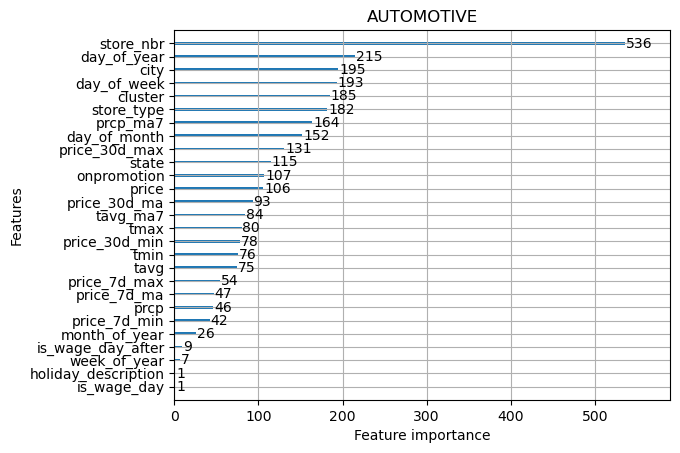

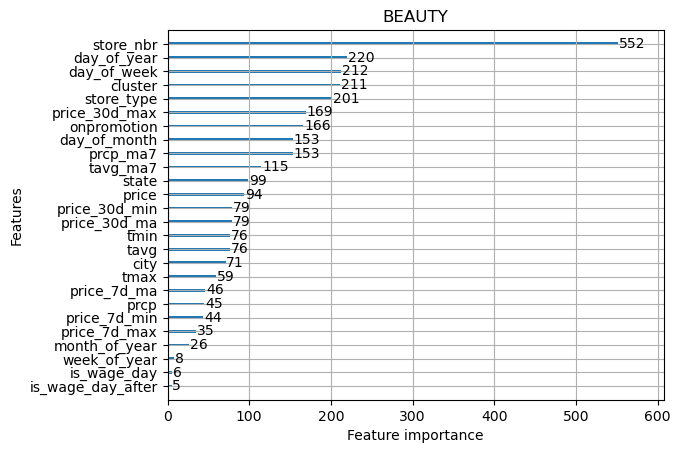

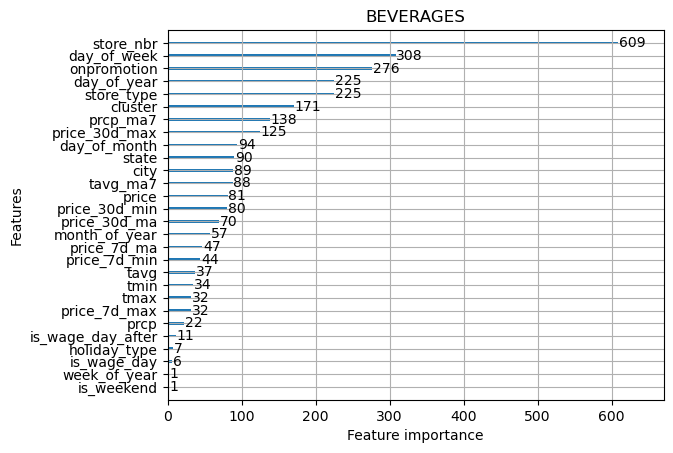

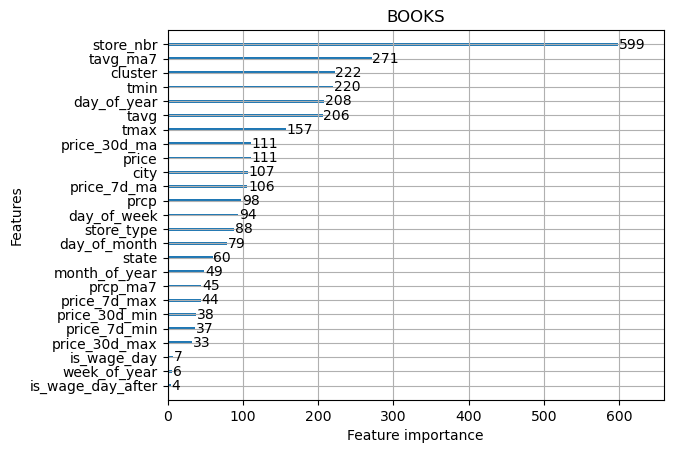

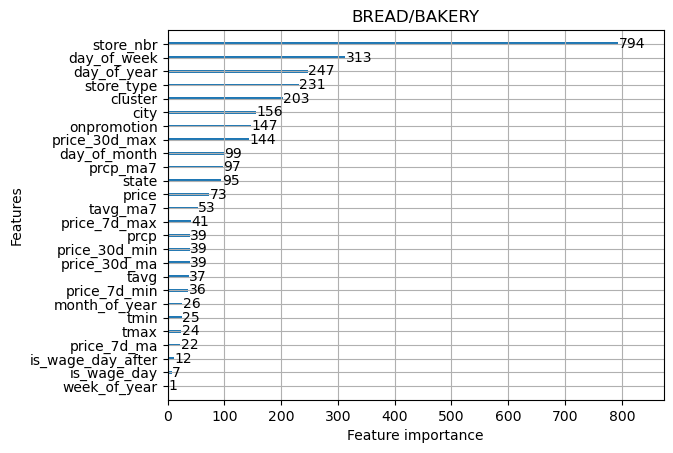

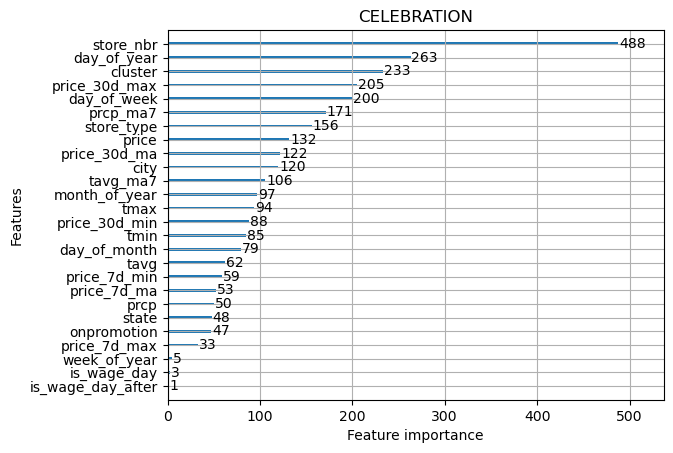

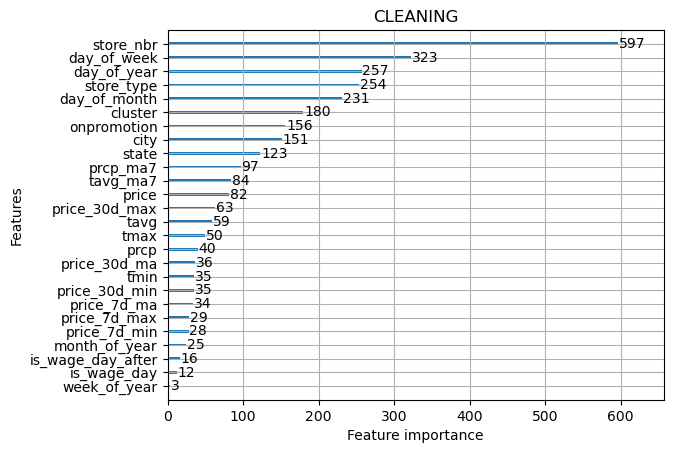

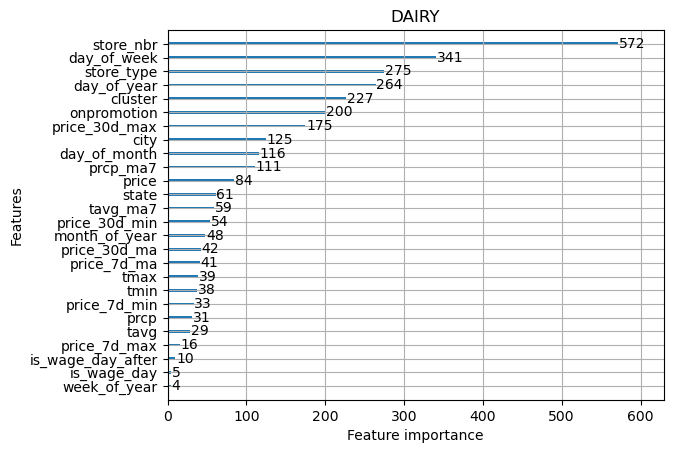

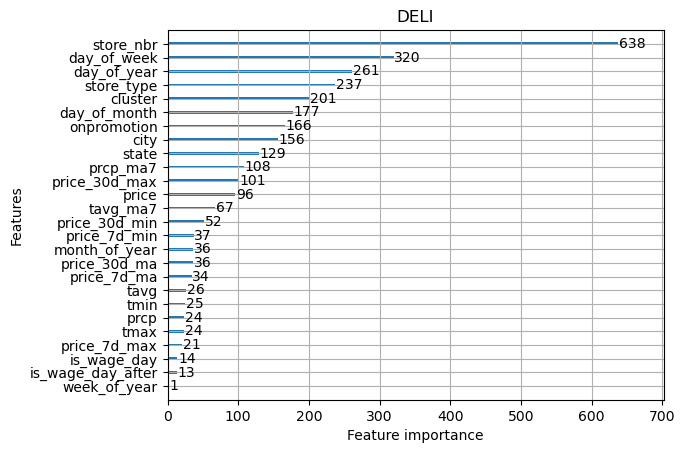

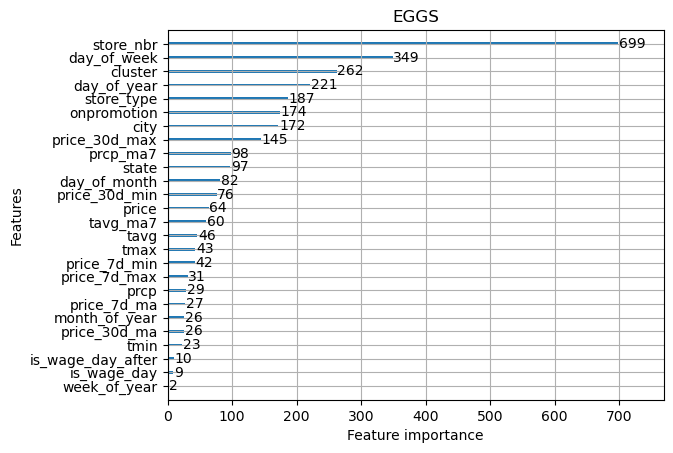

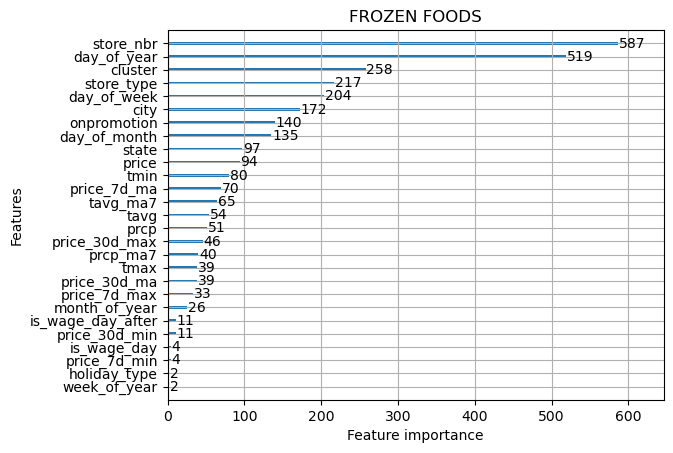

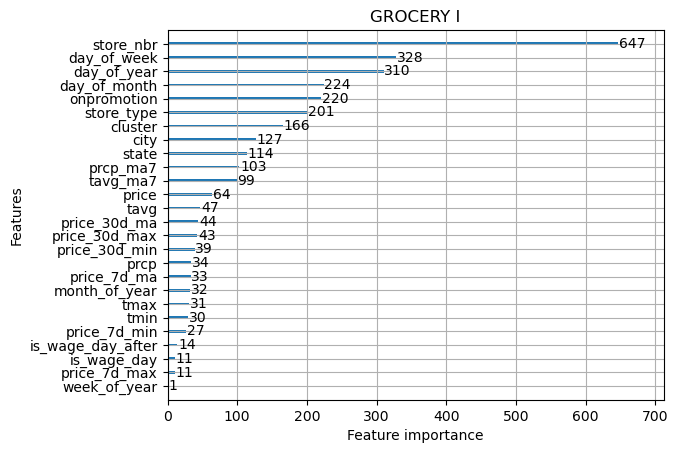

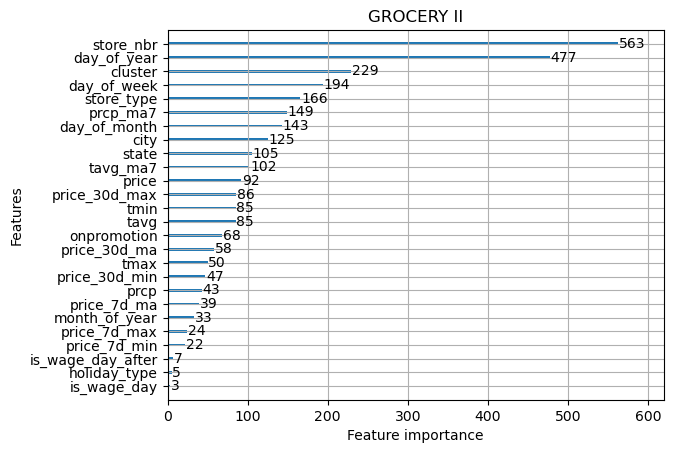

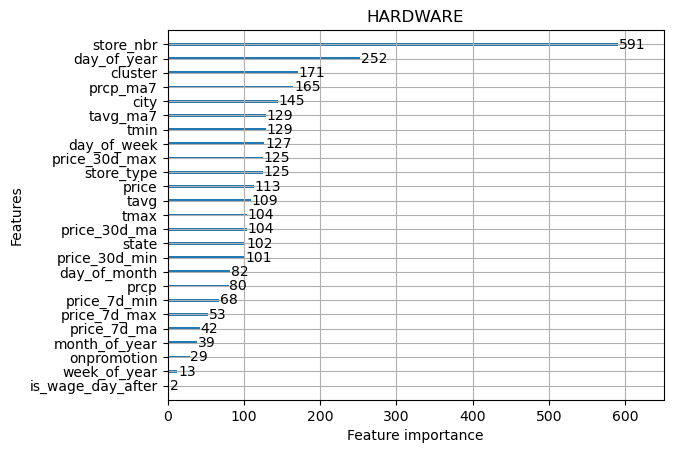

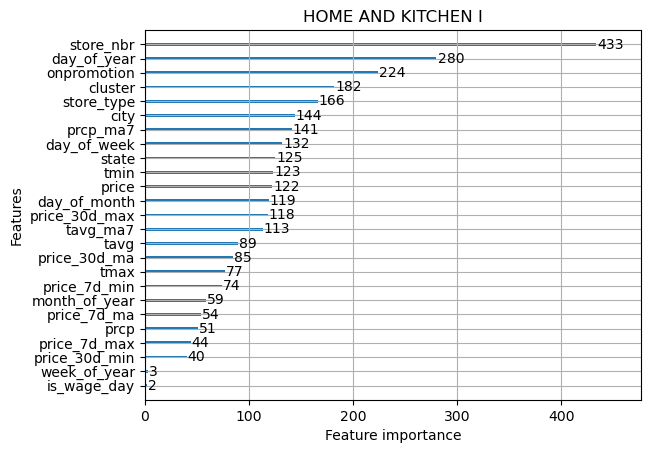

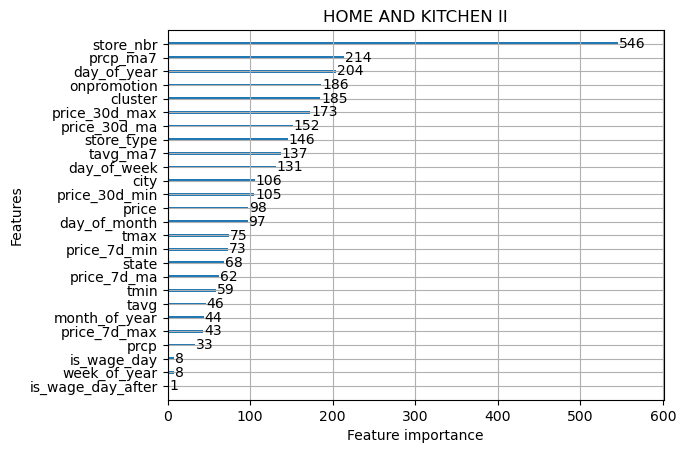

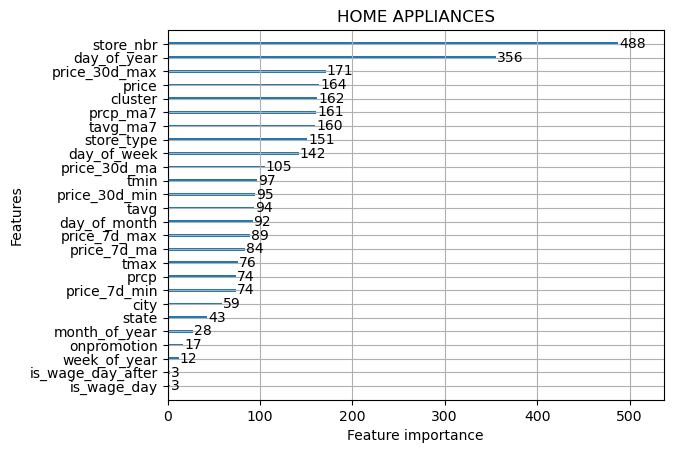

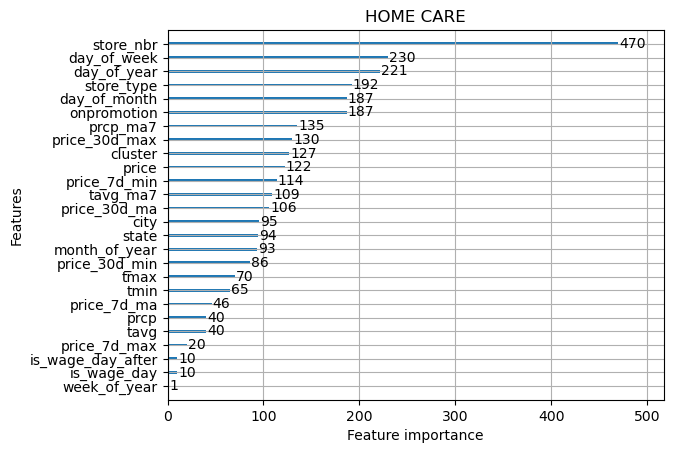

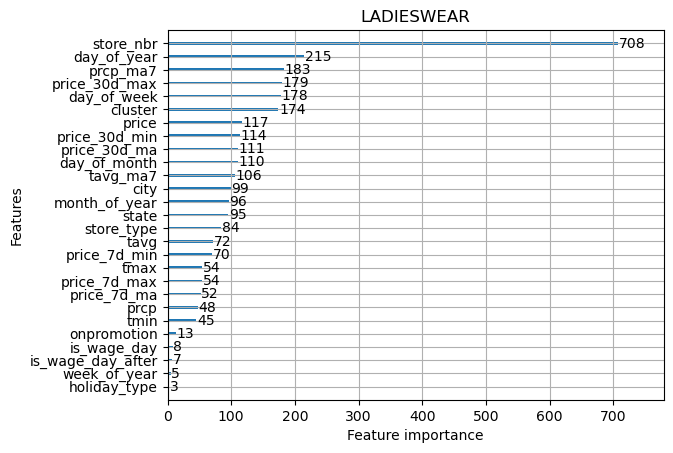

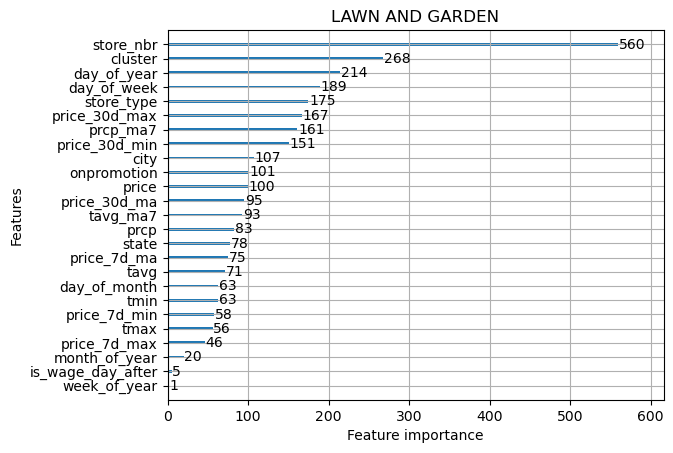

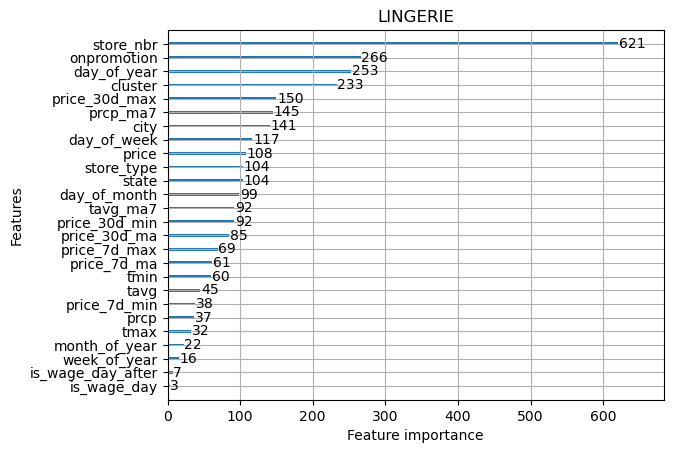

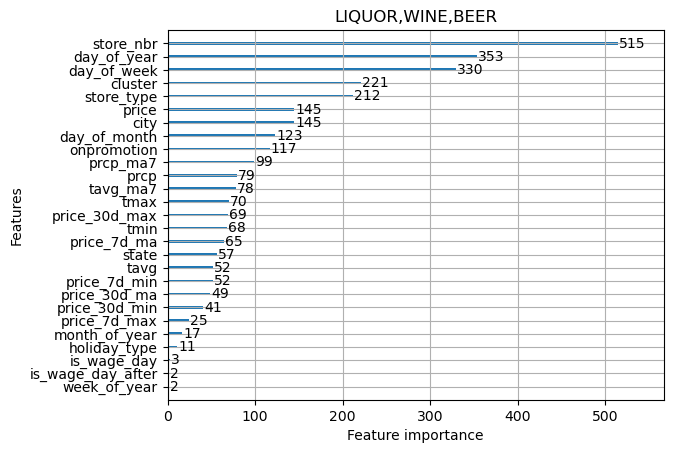

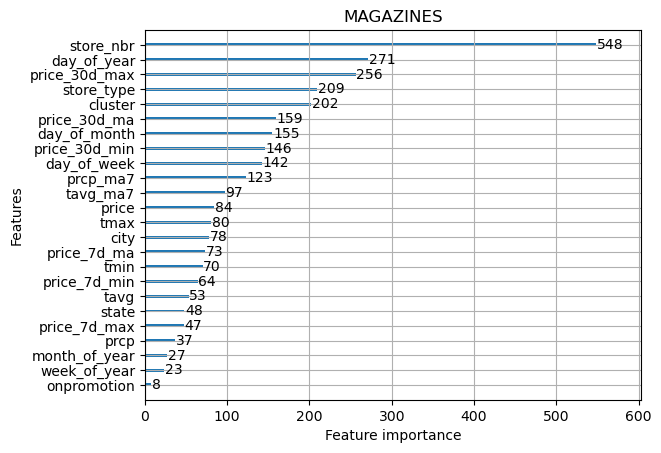

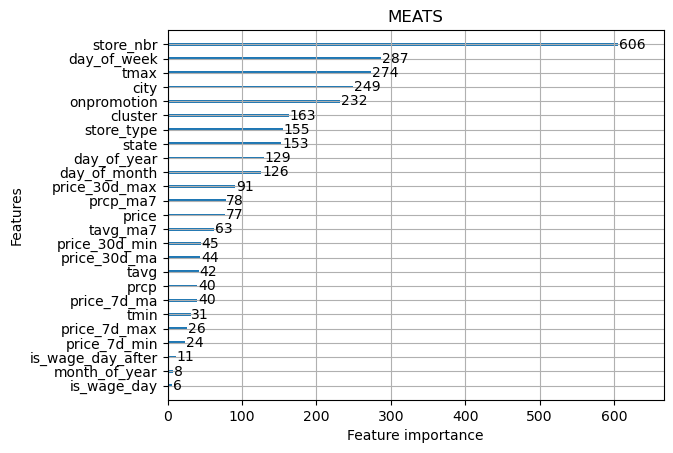

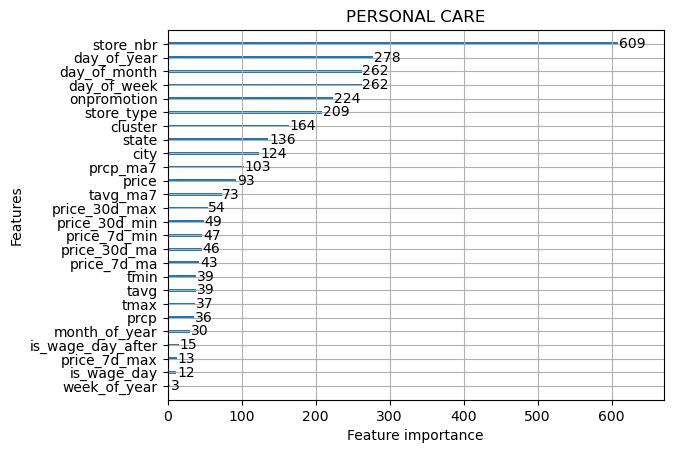

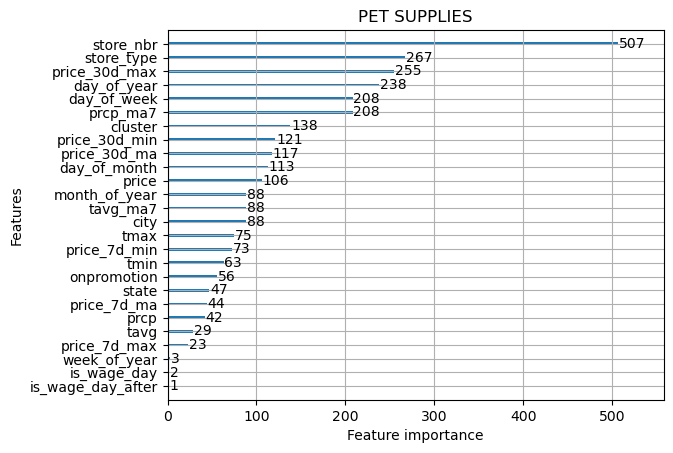

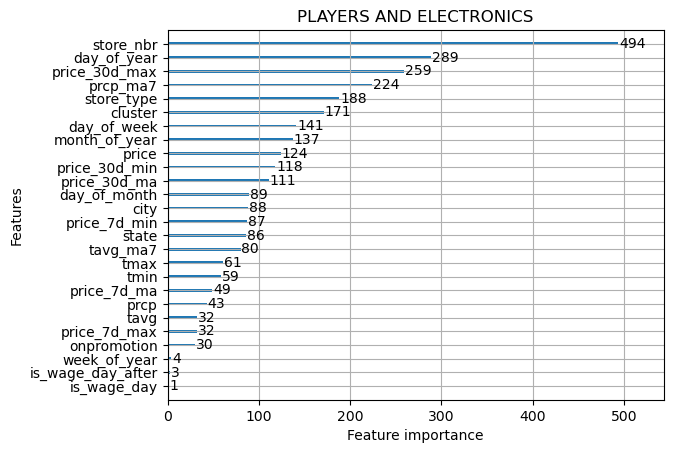

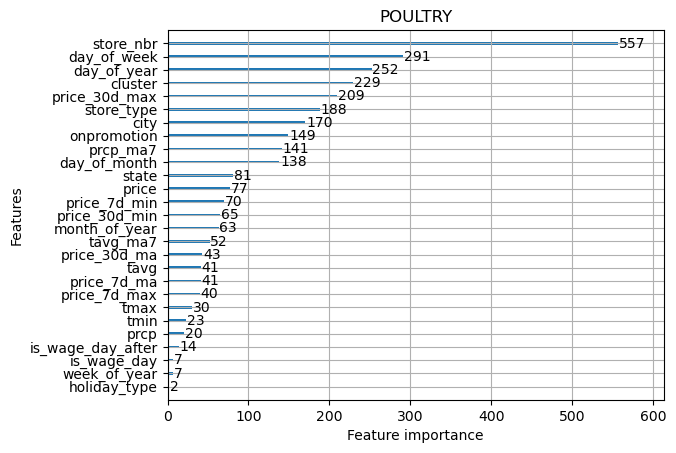

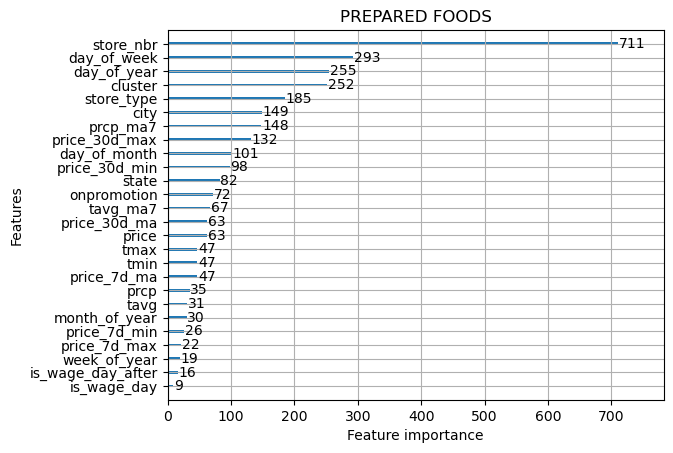

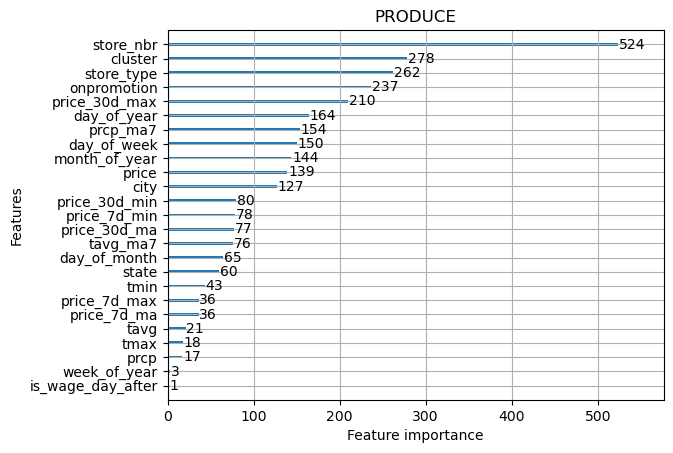

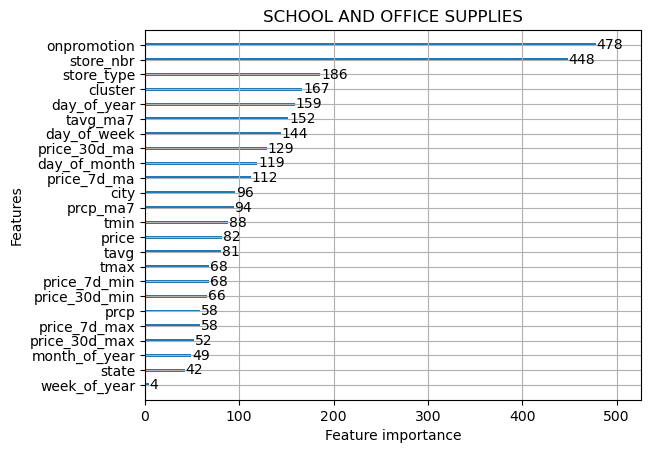

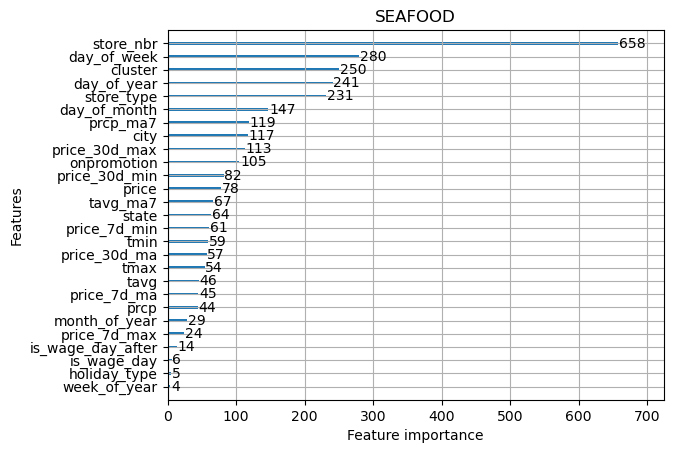

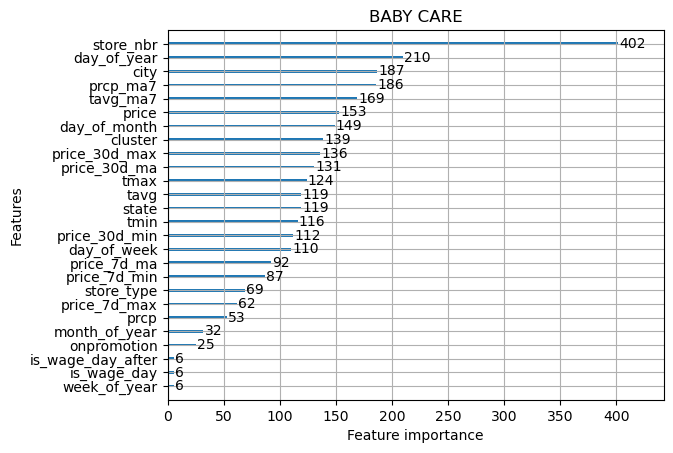

In [21]:
for fam, clf in models.items():
    fam_clean = label_encoder_map['family'].inverse_transform([fam])[0]
    lgb.plot_importance(clf, title=fam_clean)
    plt.show()
    plt.close()

In [22]:
df_train['sales_pred'] = np.nan
for fam, clf in models.items():
    X_train = df_train[df_train.family==fam].drop(['sales', 'date', 'sales_transformed', 'id', 'sales_pred'], axis=1, errors='ignore')
    df_train.loc[df_train.family == fam, 'sales_pred'] = clf.predict(X_train)

In [23]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred
0,1782,2013-01-02,1,0,2.0,0,18,12,3,13,...,2,1,2,False,False,2,4,1,0.000016,0.000029
864,3564,2013-01-03,1,0,3.0,0,18,12,3,13,...,3,1,3,False,False,2,4,1,0.000024,0.000019
1755,5346,2013-01-04,1,0,3.0,0,18,12,3,13,...,4,1,4,False,False,2,4,1,0.000024,0.000019
2657,7128,2013-01-05,1,0,5.0,0,18,12,3,13,...,5,1,5,False,False,2,4,1,0.000040,0.000021
3567,8910,2013-01-06,1,0,2.0,0,18,12,3,13,...,6,1,6,False,False,2,4,1,0.000016,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437996,2993627,2017-08-11,54,32,0.0,0,5,10,2,3,...,223,32,11,False,False,2,4,1,0.000000,0.000004
2439725,2995409,2017-08-12,54,32,1.0,1,5,10,2,3,...,224,33,12,False,False,2,4,1,0.000008,0.000021
2441454,2997191,2017-08-13,54,32,2.0,0,5,10,2,3,...,225,33,13,False,False,2,4,1,0.000016,0.000018
2443183,2998973,2017-08-14,54,32,0.0,0,5,10,2,3,...,226,33,14,False,False,2,4,1,0.000000,0.000012


In [24]:
df_train[['date', 'family', 'sales_transformed', 'store_nbr']].pivot(index='date', columns=['store_nbr', 'family'], values='sales_transformed')
df_train['sales_pred_inv'] = scaler.inverse_transform(df_train.sales_pred.values.reshape(-1, 1))
df_train.sales_pred_inv = df_train.sales_pred_inv.clip(lower=0)
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred,sales_pred_inv
0,1782,2013-01-02,1,0,2.0,0,18,12,3,13,...,1,2,False,False,2,4,1,0.000016,0.000029,3.567531
864,3564,2013-01-03,1,0,3.0,0,18,12,3,13,...,1,3,False,False,2,4,1,0.000024,0.000019,2.396526
1755,5346,2013-01-04,1,0,3.0,0,18,12,3,13,...,1,4,False,False,2,4,1,0.000024,0.000019,2.428809
2657,7128,2013-01-05,1,0,5.0,0,18,12,3,13,...,1,5,False,False,2,4,1,0.000040,0.000021,2.674362
3567,8910,2013-01-06,1,0,2.0,0,18,12,3,13,...,1,6,False,False,2,4,1,0.000016,0.000011,1.340936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437996,2993627,2017-08-11,54,32,0.0,0,5,10,2,3,...,32,11,False,False,2,4,1,0.000000,0.000004,0.541781
2439725,2995409,2017-08-12,54,32,1.0,1,5,10,2,3,...,33,12,False,False,2,4,1,0.000008,0.000021,2.580036
2441454,2997191,2017-08-13,54,32,2.0,0,5,10,2,3,...,33,13,False,False,2,4,1,0.000016,0.000018,2.303196
2443183,2998973,2017-08-14,54,32,0.0,0,5,10,2,3,...,33,14,False,False,2,4,1,0.000000,0.000012,1.499847


In [25]:
df_agg = df_train[['date', 'family', 'store_nbr', 'sales']].pivot_table(index='date', columns='store_nbr', values='sales', aggfunc='sum')
df_agg_pred = df_train[['date', 'family', 'sales_pred_inv', 'store_nbr']].pivot_table(index='date', columns='store_nbr', values='sales_pred_inv', aggfunc='sum')

Text(0.5, 1.0, 'Store Number: 4')

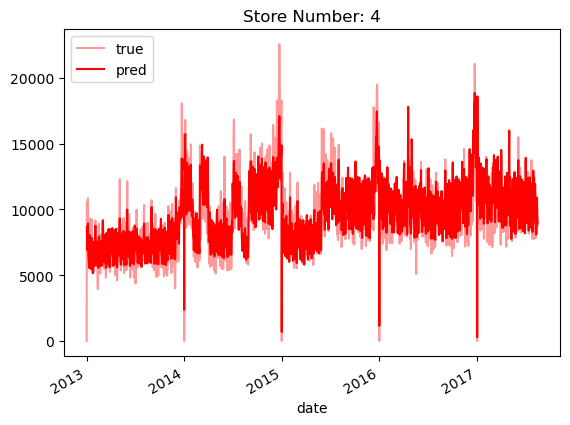

In [26]:
lookback = -20000
store_num = 4

ax = df_agg.fillna(0).iloc[lookback:,store_num:store_num+1].plot(alpha=0.4, color='r')
df_agg_pred.iloc[lookback:,store_num:store_num+1].plot(ax=ax, color='r')
ax.legend(['true', 'pred'])
ax.set_title(f'Store Number: {store_num}')

**Running model on test data**

In [27]:
df_test, _, _ = preprocess(df_test_partial, label_encoder_map)
df_test['sales'] = np.nan
for fam in df_test.family.unique():
    clf = models[fam]
    X_test = df_test[df_test.family==fam].drop(['date', 'date_timestamp', 'transactions', 'id', 'sales'], axis=1, errors='ignore')
    df_test.loc[df_test.family==fam, 'sales'] = scaler.inverse_transform(clf.predict(X_test).reshape(-1, 1))
    

df_test.sales = df_test.sales.clip(lower=0)

merging...
         id       date  store_nbr                      family  onpromotion  \
0   3000888 2017-08-16          1                  AUTOMOTIVE            0   
1   3000889 2017-08-16          1                   BABY CARE            0   
2   3000890 2017-08-16          1                      BEAUTY            2   
3   3000891 2017-08-16          1                   BEVERAGES           20   
4   3000892 2017-08-16          1                       BOOKS            0   
5   3000893 2017-08-16          1                BREAD/BAKERY           12   
6   3000894 2017-08-16          1                 CELEBRATION            0   
7   3000895 2017-08-16          1                    CLEANING           25   
8   3000896 2017-08-16          1                       DAIRY           45   
9   3000897 2017-08-16          1                        DELI           18   
10  3000898 2017-08-16          1                        EGGS            1   
11  3000899 2017-08-16          1                FROZ

Text(0.5, 1.0, 'BEAUTY')

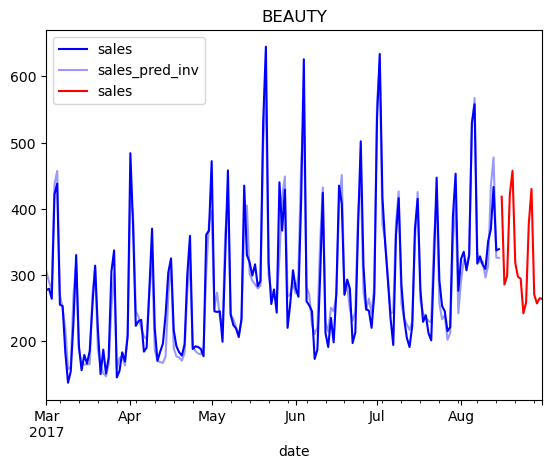

In [28]:
fam = 2
fam_clean = label_encoder_map['family'].inverse_transform([fam])[0]
start = '2017-03-01'
ax = df_train[(df_train.family==fam)&(df_train.date>=start)][['date', 'sales']].groupby('date').sum().plot(color='b')
df_train[(df_train.family==fam)&(df_train.date>=start)][['date', 'sales_pred_inv']].groupby('date').sum().plot(alpha=0.4, color='b', ax=ax)
df_test[df_test.family==fam][['date', 'sales']].groupby('date').sum().plot(ax=ax, color='r')
ax.set_title(fam_clean)

In [29]:
df_test

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,price,...,month_of_year,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales
0,3000888,2017-08-16,1,0,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,4.329321
1,3000889,2017-08-16,1,1,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,0.065747
2,3000890,2017-08-16,1,2,2,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,5.901899
3,3000891,2017-08-16,1,3,20,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,2364.611456
4,3000892,2017-08-16,1,4,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,0.142901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,3016657,2017-08-24,50,28,0,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,320.326211
15770,3016658,2017-08-24,50,29,0,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,81.990488
15771,3016659,2017-08-24,50,30,2,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,1655.968900
15772,3016660,2017-08-24,50,31,13,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,234.553459


In [30]:
df_test[['id', 'sales']].to_csv('/kaggle/working/out.csv', index=False)